# Определение возраста покупателей

## Исследовательский анализ данных

### Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

### Открыть датасет

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Загрузка таблицы

In [ ]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
data.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Text(0, 0.5, 'Кол-во')

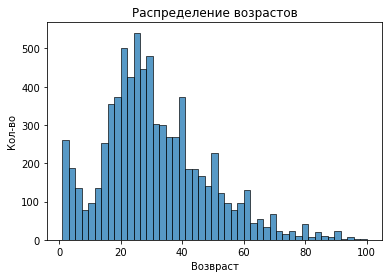

In [ ]:
# seaborn histogram
sns.histplot(data['real_age'], kde=False)
# Add labels
plt.title('Распределение возрастов')
plt.xlabel('Возвраст')
plt.ylabel('Кол-во')

In [ ]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

**Вывод**

Всего в выборке 7591 фотография.

- Распределние возрастов - скошенное.
- Среднее значение возраса - 31 год
- Пик гистограммы - 30 лет
- Мин. возраст 1 год
- Макс. возраст - 100 лет
- присутствует второй небольшой пик - возраст от 1 до 8 лет.

Детей до 5 лет нет необходимости анализировать. В этом возрасте дети не могут покупать самостоятельно. Так же возраста старше 60 лет имеют маленькое кол-во в выборке и будут давать большую погрешность. Их можно отнести к 1 группе - пенсионеры.

-----
Комментарий:

В разборе задачи предлагается решить задачу регрессии. Но на мой взгляд, для решения поставленных целей больше подходит многоклассовая классификация или регрессия, но "сглаженная" по группам.
Можно было бы разбить датасет на классы:
- дети до 5 лет - для всех детей обозначить возраст 4
- от 5 до 18 разбить на 2 группы
- от 18 до 60 лет - разбить на классы по 5 лет и присвоить каждому посетителю класс, в который он попадает.
- старше 60 лет сгруппировать в 1 класс - 61 например.

Модели будет проще предсказывать группу, к котрой относится фотография лица.
Повысится точность модели.
На мой взгляд, для рекомендательной системы и для контроля возраста 18 лет этого будет достаточно.

Пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.

#### Загрузка изображений

In [ ]:
path = '/datasets/faces/final_files/'

datagen = ImageDataGenerator()


train_datagen = ImageDataGenerator(validation_split=0.1,
                                   rescale=1/255.
                                  )
validation_datagen = ImageDataGenerator(validation_split=0.1, rescale=1/255.)


train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=data[:106],
    directory=path,
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    shuffle=True,
    seed=12345
)

val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=data[:106],
    directory=path,
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  #'multi_output', 'input', None, 'sparse', 'categorical', 'binary', 'raw'
    subset='validation',
    shuffle=True,
    seed=12345)

Found 96 validated image filenames.
Found 10 validated image filenames.


In [ ]:
features, target = next(train_datagen_flow)

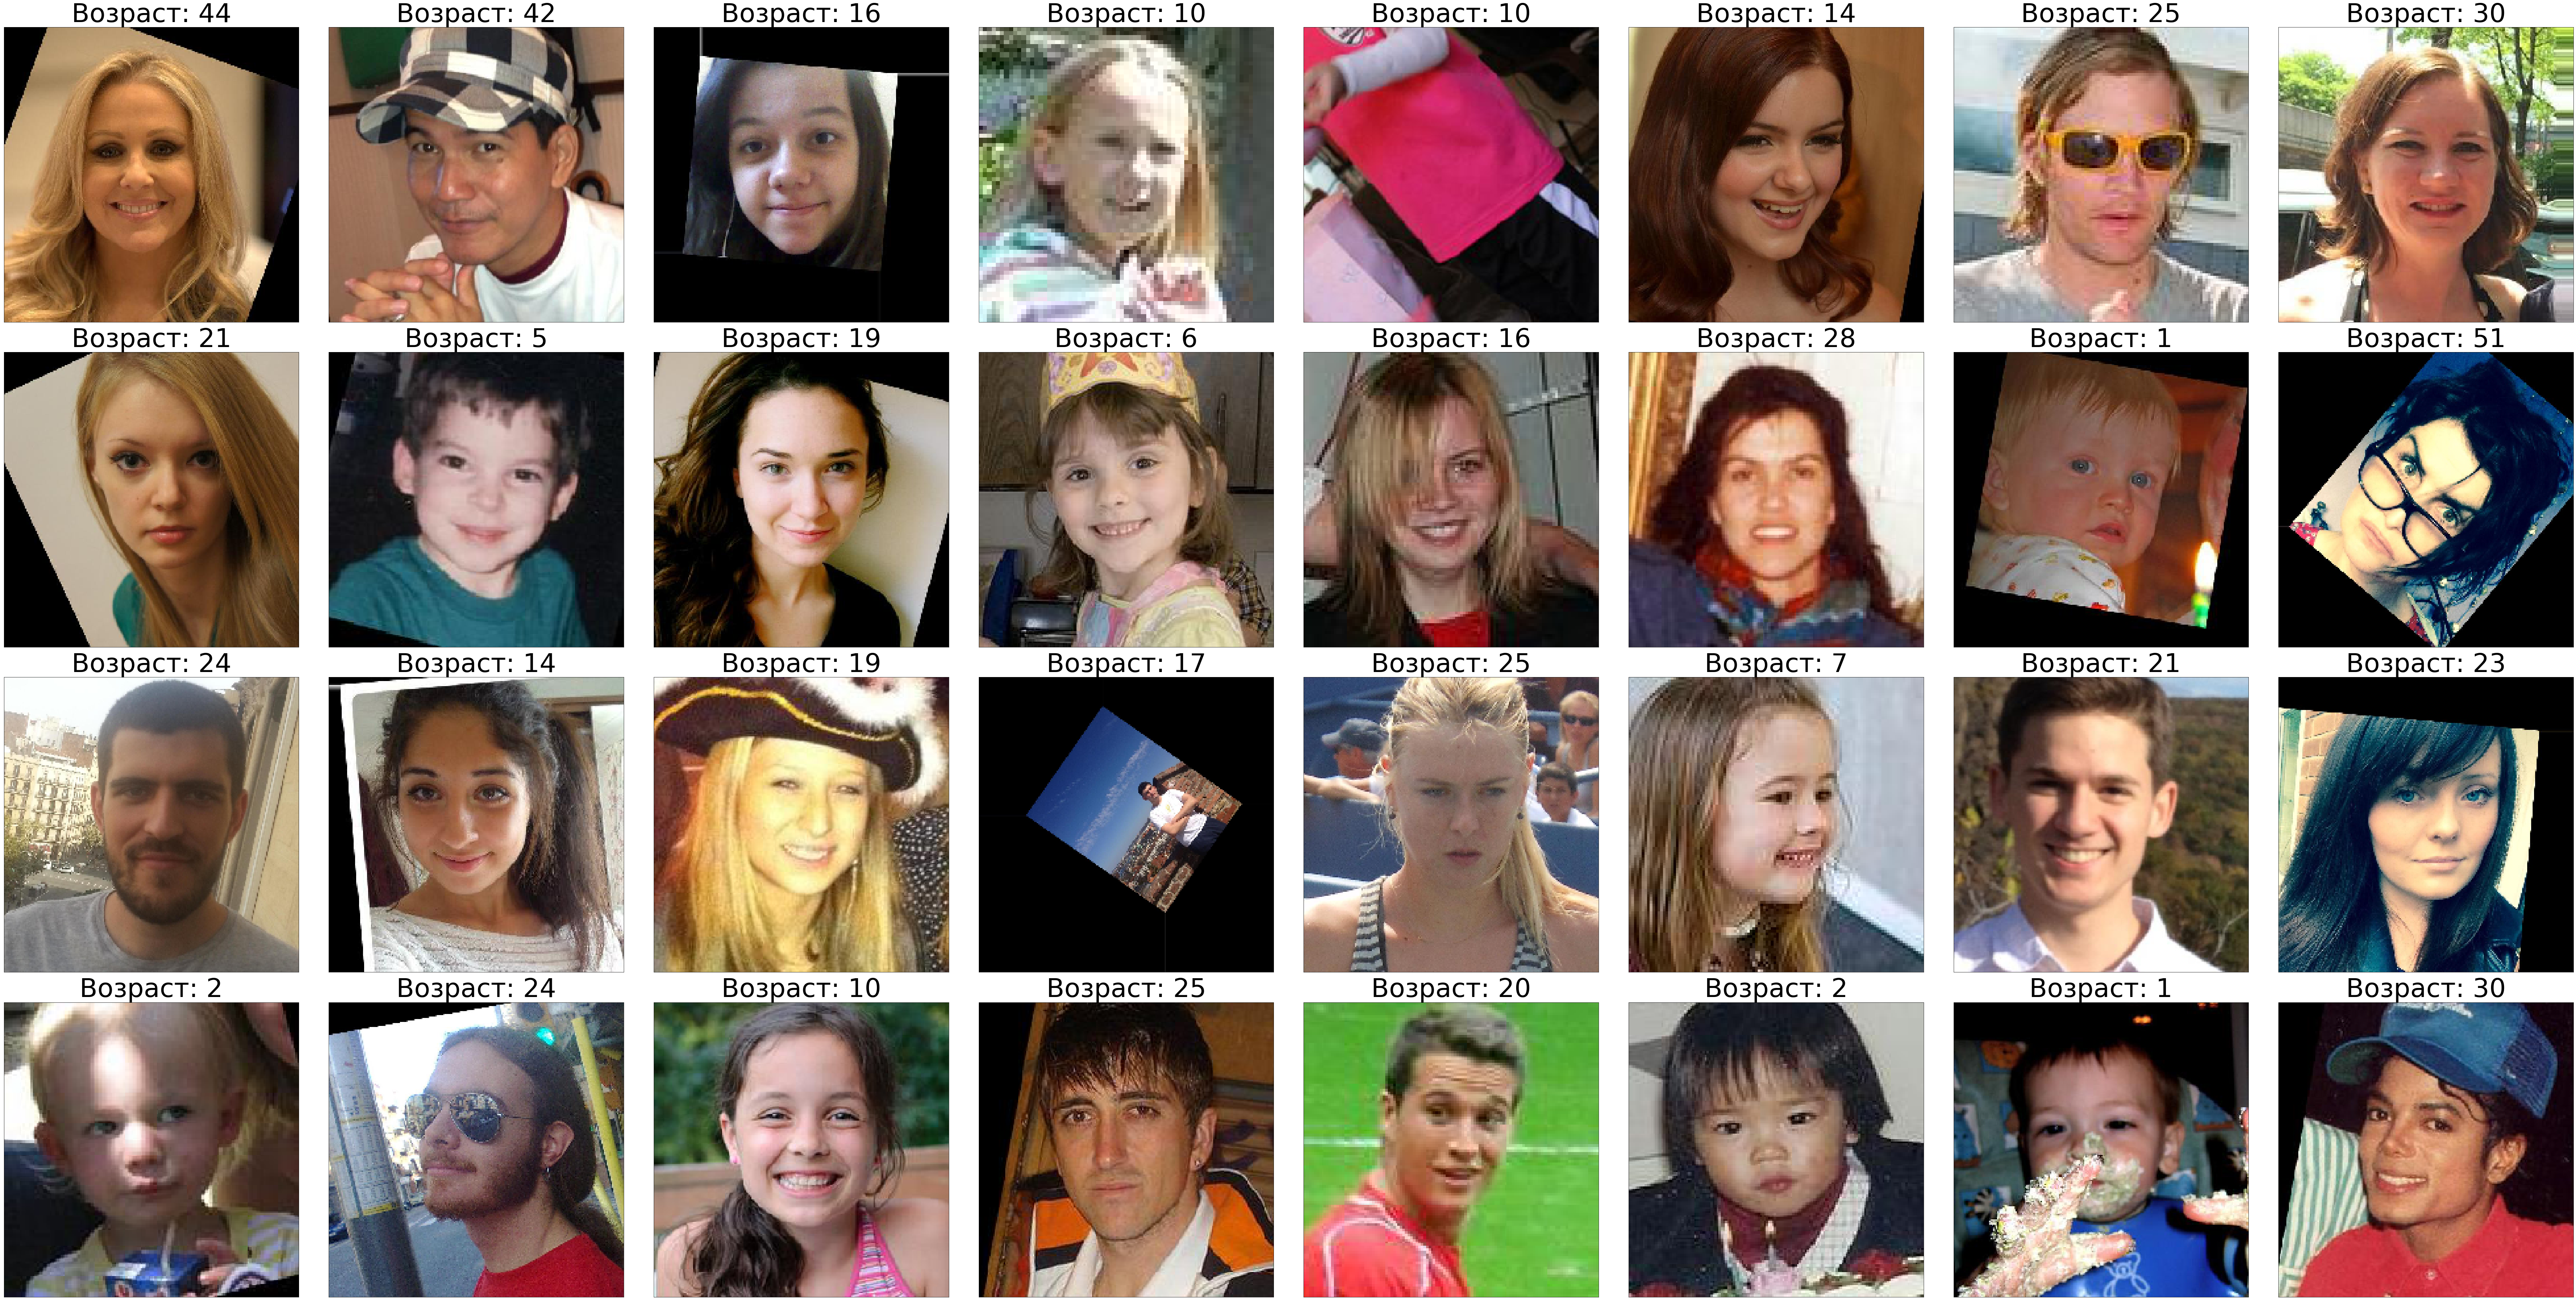

In [ ]:
# выводим 16 изображений
fig = plt.figure(figsize=(100,100))
for i in range(32):
    fig.add_subplot(8, 8, i+1).set_title('Возраст: ' + str(target[i]), size=72)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Датасет состоит из различных фотографий:
- полнокадровые фотографии лиц
- фотографии содержащие полностью человека
- с черной рамкой
    - фотографии лиц вырезанные из общих фотографий
    - повернутые фотографии (примерно до 60 градусов)
    - увеличенные фотографии
    - вытянутые фотографии (сузили по ширине, измененные пропорции)
- фотографии с обрезанными лицами
- фотографии без лиц
- повторяющиеся фотографии
- фотографии с лицами в маленьком масштабе

и различные их сочетания


В датаесете 7591 фотография. Для тестовой выборки достаточно 10% (а возможно и меньше). Задача распознавания лиц сложная, лучше больше выделить на обучение.

### Выводы

После анализа данных стало ясно, что имеются проблемы, которые могут негативно отразиться на прогнозированни возраста:
- для людей старше 60 лет - маленькая выборка
- требуется дополнительная предобработка фотографий для приведения к стандартному виду.

    
При обучении модели можно попробовать применить различную аугментацию, чтобы сгладить некоторые моменты
- приблежение
- повороты
- отражение по горизонтали

## Обучение модели

### Код

<pre>
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):                    
    data = pd.read_csv(path + '/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1/255.
                                   ,horizontal_flip=True,
                                   rotation_range=60,
                                   zoom_range=0.15,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15
                                  )  
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
    	dataframe=data,
    	directory=path + '/final_files/',
    	x_col="file_name",
    	y_col="real_age",
    	target_size=(224, 224),
    	batch_size=32,
    	class_mode='raw',
    	subset='training',
    	shuffle=True,
    	seed=12345)
                                  
    return train_datagen_flow
    
def load_test(path):                    
    data = pd.read_csv(path + '/labels.csv')
    
    validation_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1/255.
                                  )  
    
    val_datagen_flow = validation_datagen.flow_from_dataframe(
    	dataframe=data,
    	directory=path + '/final_files/',
    	x_col="file_name",
    	y_col="real_age",
    	target_size=(224, 224),
    	batch_size=32,
    	class_mode='raw',
    	subset='validation',
    	shuffle=True,
    	seed=12345)
                                  
    return val_datagen_flow


def create_model(input_shape):    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
                    
    optimizer = Adam(lr=0.0003)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


</pre>

### Результат

<pre>
Found 6073 validated image filenames.
Found 1518 validated image filenames.


Epoch 1/10
190/190 - 110s - loss: 221.5525 - mae: 11.1373 - val_loss: 525.5345 - val_mae: 17.7300
Epoch 2/10

190/190 - 110s - loss: 147.9591 - mae: 9.3091 - val_loss: 402.2071 - val_mae: 14.9496
Epoch 3/10

190/190 - 108s - loss: 124.4703 - mae: 8.4337 - val_loss: 315.0060 - val_mae: 13.1816
Epoch 4/10

190/190 - 108s - loss: 112.9121 - mae: 8.1058 - val_loss: 166.4333 - val_mae: 9.9010
Epoch 5/10

190/190 - 108s - loss: 111.1101 - mae: 7.9957 - val_loss: 116.3367 - val_mae: 8.2846
Epoch 6/10

190/190 - 105s - loss: 104.2896 - mae: 7.7713 - val_loss: 149.4396 - val_mae: 9.5362
Epoch 7/10

190/190 - 104s - loss: 102.7923 - mae: 7.7125 - val_loss: 143.3604 - val_mae: 9.3218
Epoch 8/10

190/190 - 107s - loss: 94.9206 - mae: 7.3677 - val_loss: 82.0383 - val_mae: 7.0025
Epoch 9/10

190/190 - 98s - loss: 86.3660 - mae: 7.0714 - val_loss: 97.6432 - val_mae: 7.5886
Epoch 10/10

</pre>


## Анализ обученной модели

В проекте необходимо было обучить модель распознавать лица с значение метрики MAE < 8.
По результатам работы было получено значение метрики MAE = 6.8928

Для этого было выполнено:
- проведен анализ данных
- сделаны выводы и некоторые дальнейшие рекомендации:
    - можно разбить данные на возрастные группы
    - написать алгоритм для автоматической трансформации фотографии к единому виду
- была создана модель и проверена на основе ResNet50